# Example modeling process

### Imports

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions)
import pandas as pd
import numpy as np

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import time

### Load training data and labels

In [3]:
x_train = get_training_observations()
y_train = get_training_labels()

Getting all training observations from 'metagenome_classification.db'...
Getting all training labels from 'metagenome_classification.db'...


In [36]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000000e+00,0.000000e+00,0.0,0.004020,0.006243,0.001039,0.0,0.000000,0.003265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000e+00,0.000000e+00,0.0,0.003575,0.013739,0.001026,0.0,0.000000,0.002235,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.376880e-07,2.188440e-07,0.0,0.001619,0.016218,0.000916,0.0,0.000002,0.001711,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.0,0.002737,0.019874,0.001785,0.0,0.000000,0.003570,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.0,0.001992,0.012389,0.001154,0.0,0.000013,0.002286,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000e+00,0.000000e+00,0.0,0.001684,0.016435,0.000931,0.0,0.000000,0.001806,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000e+00,0.000000e+00,0.0,0.001404,0.023274,0.000845,0.0,0.000000,0.001497,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000e+00,0.000000e+00,0.0,0.002301,0.015752,0.000925,0.0,0.000000,0.001843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000e+00,0.000000e+00,0.0,0.001885,0.014797,0.001012,0.0,0.000000,0.001689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000e+00,0.000000e+00,0.0,0.004574,0.013601,0.000995,0.0,0.000000,0.002402,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Free-living,Saline,Hypersaline (saline)
1,Free-living,Saline,Water (saline)
2,Host-associated,Plant,Plant rhizosphere
3,Free-living,Non-saline,Soil (non-saline)
4,Free-living,Saline,Water (saline)


In [31]:
y_train['EMPO_3'].value_counts()

Soil (non-saline)          303
Water (saline)             290
Water (non-saline)         245
Subsurface (non-saline)    144
Plant rhizosphere           96
Sediment (non-saline)       73
Animal proximal gut         39
Hypersaline (saline)        15
Sediment (saline)           14
Aerosol (non-saline)         8
Plant surface                6
Surface (saline)             6
Surface (non-saline)         5
Animal corpus                4
Plant corpus                 1
Name: EMPO_3, dtype: int64

### Data manipulation
Validation splits, dimensionality reduction, etc

In [4]:
# Split into train/validation if not CV
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.2) #, random_state=1)
# Dimensionality reduction?
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(X_tr)

new_x_train = svd.transform(X_tr)
new_x_val = svd.transform(X_val)

# use Dmatrix?

In [5]:
Y1_tr, Y1_val = Y_tr['EMPO_1'], Y_val['EMPO_1'] # binary
# label encoding
lc1_tr = LabelEncoder()
lc1_tr = lc1_tr.fit(Y1_tr)
Y1_tr = lc1_tr.transform(Y1_tr)

lc1_val = LabelEncoder()
lc1_val = lc1_val.fit(Y1_val)
Y1_val = lc1_val.transform(Y1_val)

In [6]:
Y2_tr, Y2_val = Y_tr['EMPO_2'], Y_val['EMPO_2'] # binary
# label encoding
lc2_tr = LabelEncoder()
lc2_tr = lc2_tr.fit(Y2_tr)
Y2_tr = lc2_tr.transform(Y2_tr)

lc2_val = LabelEncoder()
lc2_val = lc2_val.fit(Y2_val)
Y2_val = lc2_val.transform(Y2_val)

In [7]:
Y3_tr, Y3_val = Y_tr['EMPO_3'], Y_val['EMPO_3'] # binary
# label encoding
lc3_tr = LabelEncoder()
lc3_tr = lc2_tr.fit(Y3_tr)
Y3_tr = lc2_tr.transform(Y3_tr)

lc3_val = LabelEncoder()
lc3_val = lc2_val.fit(Y3_val)
Y3_val = lc2_val.transform(Y3_val)

### Model training

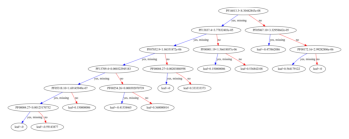

In [7]:
# without dimensionality reduction, X_tr
model1 = xgb.XGBClassifier()
model1.fit(X_tr,Y1_tr)
Y1_pred = model1.predict(X_val)
# plot single tree
plot_tree(model1)
plt.show()

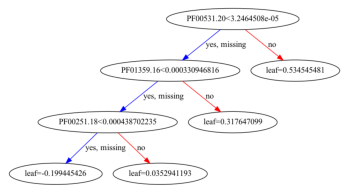

In [8]:
model2 = xgb.XGBClassifier(objective='multi:softprob')
model2.fit(X_tr,Y2_tr)
Y2_pred = model2.predict(X_val)
# plot single tree
plot_tree(model2)
plt.show()

In [ ]:
model3 = xgb.XGBClassifier(objective='multi:softprob',
                          alpha=0.5)
model3.fit(X_tr,Y3_tr)
Y3_pred = model3.predict(X_val)
# plot single tree
plot_tree(model3)
plt.show()
print("Training Set Accuracy Score on EMPO 1: ", accuracy_score(Y3_val, Y3_pred)) #0.004
# try: min child weight = 0.5
# lambda = 0.5
# alpha = 0.5
# learning_rate = 0.5 -- didn't improve model
# It turns out that the running time of xgboost scales quadratically with the number of classes.

For work here are the hyperparameters we usually try:
max_depth: integers from 8 to 20
min_child_weight: integers from 1 to 100
lambda/reg_lambda: log scaling .001 to 1
alpha/reg_alpha: log scaling .001 to 10
gamma: float between 0 and 4
learning_rate: log scaling .01 to 1
subsample: float between 0.2 and 1
colsample_bytree, colsample_bylevel, colsample_bynode: for each, floats between 0.3 and 1

There are obviously a ton of different possible combinations here, so we can either get Ed to run all the combinations using gridSearch or something, or you can pick the more important ones to test. I would just set learning rate at 0.01 and try changing the max_depth & min_child_weight parameters first

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

start = time.perf_counter()
# grid search
model3 = xgb.XGBClassifier(objective='multi:softprob', 
                      learning_rate=0.01)
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8, 10]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model3, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_tr, Y3_tr)
stop = time.perf_counter()

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')

# model3 = xgb.XGBClassifier(objective='multi:softprob',
#                           learning_rate=0.01,
#                           min_child_weight = 5,
#                           max_depth = 8,
#                            gamma = 3,
#                           )
# model3.fit(X_tr,Y3_tr)
Y3_pred = model3.predict(X_val)
plot_tree(model3)
plt.show()
print("Training Set Accuracy Score on EMPO 1: ", accuracy_score(Y3_val, Y3_pred)) #0.004
print("Model training time: %f", stop-start)
# It turns out that the running time of xgboost scales quadratically with the number of classes.

[2, 4, 6, 8, 10]
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 12, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 11, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 11, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 12, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 12, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 11, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 12, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 12, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 11, 15. Please provide the true labels exp

/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/Sophie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 2424, in log_loss
    raise ValueError(
ValueError: y_true and y_pred contain different number of classes 12, 15. Please provide the true labels exp

EMPO_3 Model Fitting Parameters

parameters | accuracy | training time
--|--|--
n/a|0.004|n/a
lr = 0.01|0.02|n/a
lr=0.01,min_child_weight=1|0.02|780s
lr=0.01,min_child_weight=1,max_depth=8|0.02|771s
lr=0.01,min_child_weight=1,max_depth=10|0.016|833s
lr=0.01,min_child_weight=5,max_depth=8|0.02|695s
lr=0.01,min_child_weight=10,max_depth=8|0.008|549s
lr=0.01,min_child_weight=1,max_depth=8, reg_lambda=0.003|0.016|842s
lr=0.01,min_child_weight=1,max_depth=8, reg_alpha=1|0.016|638s
lr=0.01,min_child_weight=5,max_depth=8, gamma=2|0.02|687s
lr=0.01,min_child_weight=5,max_depth=8, gamma=3|0.02|776s


In [ ]:
model1new = xgb.XGBClassifier()
model1new.fit(new_x_train,Y1_tr)
new_Y1_pred = model1new.predict(new_x_val)

model2new = xgb.XGBClassifier(objective='multi:softprob')
model2new.fit(new_x_train,Y2_tr)
new_Y2_pred = model2new.predict(new_x_val)

model3new = xgb.XGBClassifier(objective='multi:softprob')
model3new.fit(new_x_train,Y3_tr)
new_Y3_pred = model3new.predict(new_x_val)

### Model evaluation

In [42]:
print("Training Set Accuracy Score on EMPO 1: ", accuracy_score(Y1_val, Y1_pred))

# print("Training Set Accuracy Score on EMPO 1: ", accuracy_score(Y2_val, Y2_pred))

print("Training Set Accuracy Score on EMPO 1: ", accuracy_score(Y3_val, Y3_pred))

Training Set Accuracy Score on EMPO 1:  0.98
Training Set Accuracy Score on EMPO 1:  0.004


Training Set Accuracy Score on EMPO 1:  0.004


### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

### Save fitted model

In [9]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
from joblib import dump

# dump(clf, '../model_joblibs/example_multiclass_logreg.joblib')

['../model_joblibs/example_multiclass_logreg.joblib']